In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys
import os
from dataclasses import dataclass
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from llamawrapper import load_unemb_only, LlamaHelper
import seaborn as sns
from scipy.stats import bootstrap
from utils import plot_ci, plot_ci_plus_heatmap
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
# fix random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
sys.path.append('../tuned-lens')
from tuned_lens.nn.lenses import TunedLens,LogitLens

In [3]:
input_lang = 'fr'
target_lang = 'fr'
model_size = '7b'
prefix = "./data/langs/"
type = 'logit'

In [4]:
# Parameters
model_size = "7b"
target_lang = "fr"
input_lang = "de"
type = "tuned"


In [5]:
df_en_input = pd.read_csv(f'{prefix}{input_lang}/clean.csv').reindex()
df_en_target = pd.read_csv(f'{prefix}{target_lang}/clean.csv').reindex()
llama = AutoModelForCausalLM.from_pretrained(  # type: ignore
                f"meta-llama/Llama-2-{model_size}-hf",
                device_map={"": "cuda"},
                revision="main",
                torch_dtype="auto",
                local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )
    
latent="en"
if type == 'logit':
    llama_lens = LogitLens.from_model(llama).to("cuda")
    out_dir = f'./visuals/logit'
if type == 'tuned':
    llama_lens = TunedLens.from_model_and_pretrained(llama,f"meta-llama/Llama-2-{model_size}-hf").to("cuda")
    out_dir = f'./visuals/tuned'
if type == 'tuned-chinese':
    llama_lens = TunedLens.from_model_and_pretrained(llama,"../tuned-lens/my_lenses/chinese").to("cuda")
    out_dir = f'./visuals/tuned-chinese'
    latent = 'zh'
tokenizer = AutoTokenizer.from_pretrained(
                f"meta-llama/Llama-2-7b-hf",local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

params.pt AlignmentResearch/tuned-lens space main lens/meta-llama/Llama-2-7b-hf None


params.pt:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

(…)ens/meta-llama/Llama-2-7b-hf/config.json:   0%|          | 0.00/258 [00:00<?, ?B/s]

In [6]:
unemb = nn.Sequential(llama.model.norm, llama.lm_head)
print(unemb)
# prepare for energy plots
U = list(unemb[1].parameters())[0].detach().cpu().float()
weights = list(unemb[0].parameters())[0].detach().cpu().float()
print(f'U {U.shape} weights {weights.unsqueeze(0).shape}')
U_weighted = U.clone() 
#U_weighted = U_weighted / ((U_weighted**2).mean(dim=1, keepdim=True))**0.5
U_weighted *= weights.unsqueeze(0)
U_normalized = U_weighted / ((U_weighted**2).sum(dim=1, keepdim=True))**0.5
v = U.shape[0]
TT = U_normalized.T @ U_normalized
avgUU = (((U_normalized.T @ U_normalized)**2).sum() / v**2)**0.5
print(avgUU.item())

Sequential(
  (0): LlamaRMSNorm()
  (1): Linear(in_features=4096, out_features=32000, bias=False)
)
U torch.Size([32000, 4096]) weights torch.Size([1, 4096])


0.058621685951948166


In [7]:
count = 0
for idx, word in enumerate(df_en_target['word_translation']):
    if word in tokenizer.get_vocab() or '▁'+word in tokenizer.get_vocab():
        count += 1

print(f'for {target_lang} {count} of {len(df_en_target)} are single tokens')

if input_lang == target_lang:
    df_en_target_input = df_en_target.copy()
    df_en_target_input.rename(columns={'word_original': 'en', 
                                f'word_translation': target_lang if target_lang != 'en' else 'en_tgt'}, 
                                inplace=True)
else:
    df_en_target_input = df_en_target.merge(df_en_input, on=['word_original'], suffixes=(f'_{target_lang}', f'_{input_lang}'))
    df_en_target_input.rename(columns={'word_original': 'en', 
                                f'word_translation_{target_lang}': target_lang if target_lang != 'en' else 'en_tgt', 
                                f'word_translation_{input_lang}': input_lang if input_lang != 'en' else 'en_in'}, 
                                inplace=True)
# delete all rows where en is contained in de or fr
if target_lang != 'en':
    for i, row in df_en_target_input.iterrows():
        if row['en'].lower() in row[target_lang].lower():
            df_en_target_input.drop(i, inplace=True)

print(f'final length of df_en_{target_lang}_{input_lang}: {len(df_en_target_input)}')

for fr 68 of 118 are single tokens
final length of df_en_fr_de: 94


In [8]:
df_en_target_input

,lang_fr,en,fr,blank_prompt_original_fr,blank_prompt_translation_fr,blank_prompt_translation_masked_fr,error_fr,lang_de,de,blank_prompt_original_de,blank_prompt_translation_de,blank_prompt_translation_masked_de,error_de
0,fr,cloud,nuage,"A ""cloud"" is a visible mass of condensed water...","Un ""nuage"" est une masse visible de vapeur d'e...","Un ""___"" est une masse visible de vapeur d'eau...",no error,de,Wolke,"A ""cloud"" is a visible mass of condensed water...","Eine ""Wolke"" ist eine sichtbare Masse aus kond...","Eine ""___"" ist eine sichtbare Masse aus konden...",no error
1,fr,bag,sac,"A ""bag"" is used to carry items. Answer: ""bag"".","Un ""sac"" est utilisé pour transporter des obje...","Un ""___"" est utilisé pour transporter des obje...",no error,de,Tasche,"A ""bag"" is used to carry items. Answer: ""bag"".","Eine ""Tasche"" wird zum Tragen von Gegenständen...","Eine ""___"" wird zum Tragen von Gegenständen ve...",no error
2,fr,mouth,bouche,"A ""mouth"" is used to eat food and speak. Answe...","La ""bouche"" sert à manger et à parler. Réponse...","La ""___"" sert à manger et à parler. Réponse : ...",no error,de,Mund,"A ""mouth"" is used to eat food and speak. Answe...","Ein ""Mund"" wird zum Essen und Sprechen benutzt...","Ein ""___"" wird zum Essen und Sprechen benutzt....",no error
3,fr,soil,sol,"""A ""soil"" is used for planting trees and crops...","""Un ""sol"" est utilisé pour planter des arbres ...","""Un ""___"" est utilisé pour planter des arbres ...",no error,de,Boden,"""A ""soil"" is used for planting trees and crops...","""Ein ""Boden"" wird für die Anpflanzung von Bäum...","""Ein ""___"" wird für die Anpflanzung von Bäumen...",no error
4,fr,mountain,montagne,"A ""mountain"" is a large natural elevation of t...","Une ""montagne"" est une grande élévation nature...","Une ""___"" est une grande élévation naturelle d...",no error,de,Berg,"A ""mountain"" is a large natural elevation of t...","Ein ""Berg"" ist eine große natürliche Erhebung ...","Ein ""___"" ist eine große natürliche Erhebung a...",no error
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,fr,office,bureau,"An ""office"" is a place where people usually do...","Un ""bureau"" est un endroit où les gens font ha...","Un ""___"" est un endroit où les gens font habit...",no error,de,Büro,"An ""office"" is a place where people usually do...","Ein ""Büro"" ist ein Ort, an dem Menschen normal...","Ein ""___"" ist ein Ort, an dem Menschen normale...",no error
105,fr,rise,hausse,"""A ""rise"" is used to describe an increase or u...","""Une ""hausse"" est utilisée pour décrire une au...","""Une ""___"" est utilisée pour décrire une augme...",no error,de,Anstieg,"""A ""rise"" is used to describe an increase or u...","""Ein ""Anstieg"" wird verwendet, um einen Anstie...","""Ein ""___"" wird verwendet, um einen Anstieg od...",no error
106,fr,left,gauche,"'A ""left"" is a direction opposite to right. An...","Une ""gauche"" est une direction opposée à la dr...","Une ""___"" est une direction opposée à la droit...",no error,de,links,"'A ""left"" is a direction opposite to right. An...","Ein ""links"" ist eine Richtung, die der rechten...","Ein ""___"" ist eine Richtung, die der rechten e...",no error
107,fr,power,pouvoir,"""A ""power"" is used to control or influence peo...","""Un ""pouvoir"" est utilisé pour contrôler ou in...","""Un ""___"" est utilisé pour contrôler ou influe...",no error,de,Macht,"""A ""power"" is used to control or influence peo...","""Eine ""Macht"" wird benutzt, um Menschen oder D...","""Eine ""___"" wird benutzt, um Menschen oder Din...",no error


In [9]:
def token_prefixes(token_str: str):
    n = len(token_str)
    tokens = [token_str[:i] for i in range(1, n+1)]
    return tokens 

def add_spaces(tokens):
    return ['▁' + t for t in tokens] + tokens

def capitalizations(tokens):
    return list(set(tokens))

def unicode_prefix_tokid(zh_char = "云", tokenizer=tokenizer):
    start = zh_char.encode().__str__()[2:-1].split('\\x')[1]
    unicode_format = '<0x%s>'
    start_key = unicode_format%start.upper()
    if start_key in tokenizer.get_vocab():
        return tokenizer.get_vocab()[start_key]
    return None

def process_tokens(token_str: str, tokenizer, lang):
    with_prefixes = token_prefixes(token_str)
    with_spaces = add_spaces(with_prefixes)
    with_capitalizations = capitalizations(with_spaces)
    final_tokens = []
    for tok in with_capitalizations:
        if tok in tokenizer.get_vocab():
            final_tokens.append(tokenizer.get_vocab()[tok])
    if lang in ['zh', 'ru']:
        tokid = unicode_prefix_tokid(token_str, tokenizer)
        if tokid is not None:
            final_tokens.append(tokid)
    return final_tokens

In [10]:

id2voc = {id:voc for voc, id in tokenizer.get_vocab().items()}
def get_tokens(token_ids, id2voc=id2voc):
    return [id2voc[tokid] for tokid in token_ids]

def compute_entropy(probas):
    return (-probas*torch.log2(probas)).sum(dim=-1)

lang2name = {'fr': 'Français', 'de': 'Deutsch', 'ru': 'Русский', 'en': 'English', 'zh': '中文'}
def sample(df, ind, k=5, tokenizer=tokenizer, lang1='fr', lang2='de', lang_latent=latent):
    df = df.reset_index(drop=True)
    temp = df[df.index!=ind]
    sample = pd.concat([temp.sample(k-1), df[df.index==ind]], axis=0)
    prompt = ""
    for idx, (df_idx, row) in enumerate(sample.iterrows()):
        if idx < k-1:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "{row[lang2]}"\n'
        else:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "'
            in_token_str = row[lang1]
            out_token_str = row[lang2]
            out_token_id = process_tokens(out_token_str, tokenizer, lang2)
            latent_token_str = row[lang_latent]
            latent_token_id = process_tokens(latent_token_str, tokenizer, latent)
            intersection = set(out_token_id).intersection(set(latent_token_id))
            if len(out_token_id) == 0 or len(latent_token_id) == 0:
                yield None
            if lang2 != 'en' and len(intersection) > 0:
                yield None
            yield {'prompt': prompt, 
                'out_token_id': out_token_id, 
                'out_token_str': out_token_str,
                'latent_token_id': latent_token_id, 
                'latent_token_str': latent_token_str, 
                'in_token_str': in_token_str}

In [11]:
dataset = []
for ind in tqdm(range(len(df_en_target_input))):
    d = next(sample(df_en_target_input, ind, lang1=input_lang, lang2=target_lang))
    if d is None:
        continue
    dataset.append(d)

  0%|                                                                                                                                                                                                                        | 0/94 [00:00<?, ?it/s]

  1%|██▏                                                                                                                                                                                                             | 1/94 [00:00<00:20,  4.64it/s]

  2%|████▍                                                                                                                                                                                                           | 2/94 [00:00<00:16,  5.67it/s]

  3%|██████▋                                                                                                                                                                                                         | 3/94 [00:00<00:17,  5.11it/s]

  4%|████████▊                                                                                                                                                                                                       | 4/94 [00:00<00:16,  5.40it/s]

  5%|███████████                                                                                                                                                                                                     | 5/94 [00:01<00:20,  4.34it/s]

  6%|█████████████▎                                                                                                                                                                                                  | 6/94 [00:01<00:18,  4.73it/s]

  7%|███████████████▍                                                                                                                                                                                                | 7/94 [00:01<00:18,  4.76it/s]

  9%|█████████████████▋                                                                                                                                                                                              | 8/94 [00:01<00:17,  4.88it/s]

 10%|███████████████████▉                                                                                                                                                                                            | 9/94 [00:01<00:17,  4.79it/s]

 11%|██████████████████████                                                                                                                                                                                         | 10/94 [00:02<00:19,  4.32it/s]

 12%|████████████████████████▏                                                                                                                                                                                      | 11/94 [00:02<00:17,  4.68it/s]

 13%|██████████████████████████▍                                                                                                                                                                                    | 12/94 [00:02<00:16,  4.97it/s]

 14%|████████████████████████████▋                                                                                                                                                                                  | 13/94 [00:02<00:17,  4.67it/s]

 15%|██████████████████████████████▊                                                                                                                                                                                | 14/94 [00:02<00:16,  4.77it/s]

 16%|█████████████████████████████████                                                                                                                                                                              | 15/94 [00:03<00:17,  4.54it/s]

 17%|███████████████████████████████████▏                                                                                                                                                                           | 16/94 [00:03<00:17,  4.57it/s]

 18%|█████████████████████████████████████▍                                                                                                                                                                         | 17/94 [00:03<00:16,  4.70it/s]

 19%|███████████████████████████████████████▋                                                                                                                                                                       | 18/94 [00:03<00:14,  5.14it/s]

 20%|█████████████████████████████████████████▊                                                                                                                                                                     | 19/94 [00:03<00:14,  5.20it/s]

 21%|████████████████████████████████████████████                                                                                                                                                                   | 20/94 [00:04<00:14,  5.17it/s]

 22%|██████████████████████████████████████████████▏                                                                                                                                                                | 21/94 [00:04<00:14,  5.05it/s]

 23%|████████████████████████████████████████████████▍                                                                                                                                                              | 22/94 [00:04<00:13,  5.46it/s]

 24%|██████████████████████████████████████████████████▋                                                                                                                                                            | 23/94 [00:04<00:12,  5.55it/s]

 26%|████████████████████████████████████████████████████▊                                                                                                                                                          | 24/94 [00:04<00:14,  4.78it/s]

 27%|███████████████████████████████████████████████████████                                                                                                                                                        | 25/94 [00:05<00:13,  4.99it/s]

 28%|█████████████████████████████████████████████████████████▎                                                                                                                                                     | 26/94 [00:05<00:13,  4.92it/s]

 29%|███████████████████████████████████████████████████████████▍                                                                                                                                                   | 27/94 [00:05<00:13,  4.87it/s]

 30%|█████████████████████████████████████████████████████████████▋                                                                                                                                                 | 28/94 [00:05<00:13,  4.97it/s]

 31%|███████████████████████████████████████████████████████████████▊                                                                                                                                               | 29/94 [00:05<00:13,  4.81it/s]

 32%|██████████████████████████████████████████████████████████████████                                                                                                                                             | 30/94 [00:06<00:12,  5.33it/s]

 33%|████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 31/94 [00:06<00:12,  5.25it/s]

 34%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 32/94 [00:06<00:10,  5.69it/s]

 35%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 33/94 [00:06<00:11,  5.31it/s]

 36%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 34/94 [00:06<00:11,  5.40it/s]

 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 35/94 [00:07<00:11,  4.94it/s]

 38%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 36/94 [00:07<00:10,  5.55it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 37/94 [00:07<00:09,  5.73it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 38/94 [00:07<00:10,  5.21it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 39/94 [00:07<00:10,  5.06it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 40/94 [00:07<00:10,  5.16it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 41/94 [00:08<00:10,  5.20it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 42/94 [00:08<00:09,  5.22it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 43/94 [00:08<00:09,  5.38it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 44/94 [00:08<00:08,  5.75it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 45/94 [00:08<00:08,  5.89it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 46/94 [00:09<00:09,  5.21it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 47/94 [00:09<00:09,  5.05it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 48/94 [00:09<00:07,  5.85it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 49/94 [00:09<00:08,  5.32it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 50/94 [00:09<00:08,  5.39it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 51/94 [00:10<00:08,  4.97it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 52/94 [00:10<00:08,  4.68it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 53/94 [00:10<00:09,  4.32it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 54/94 [00:10<00:09,  4.42it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 55/94 [00:11<00:08,  4.36it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 56/94 [00:11<00:09,  4.16it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 57/94 [00:11<00:09,  4.06it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 58/94 [00:11<00:08,  4.01it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 59/94 [00:12<00:08,  4.18it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 60/94 [00:12<00:07,  4.45it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 61/94 [00:12<00:07,  4.50it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 62/94 [00:12<00:06,  4.65it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 63/94 [00:12<00:07,  4.30it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 64/94 [00:13<00:06,  4.37it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 65/94 [00:13<00:06,  4.33it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 66/94 [00:13<00:07,  3.94it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 67/94 [00:13<00:06,  4.04it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 68/94 [00:14<00:07,  3.43it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 69/94 [00:14<00:06,  3.60it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 70/94 [00:14<00:06,  3.88it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 71/94 [00:15<00:06,  3.66it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 72/94 [00:15<00:05,  3.71it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 73/94 [00:15<00:05,  3.56it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 74/94 [00:15<00:06,  3.31it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 75/94 [00:16<00:05,  3.76it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 76/94 [00:16<00:04,  3.83it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 77/94 [00:16<00:04,  3.97it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 78/94 [00:16<00:03,  4.08it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 79/94 [00:17<00:03,  4.10it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 80/94 [00:17<00:03,  4.30it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 81/94 [00:17<00:03,  3.89it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 82/94 [00:17<00:03,  3.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 83/94 [00:18<00:02,  4.12it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 84/94 [00:18<00:02,  4.30it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 85/94 [00:18<00:01,  4.70it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 86/94 [00:18<00:01,  4.34it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 87/94 [00:18<00:01,  4.31it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 88/94 [00:19<00:01,  4.53it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 89/94 [00:19<00:01,  4.18it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 90/94 [00:19<00:00,  4.10it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 91/94 [00:19<00:00,  4.30it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 92/94 [00:20<00:00,  4.41it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 93/94 [00:20<00:00,  4.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.29it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.56it/s]

In [12]:
df = pd.DataFrame(dataset)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
df.to_csv(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_dataset.csv', index=False)

In [13]:
df

,prompt,out_token_id,out_token_str,latent_token_id,latent_token_str,in_token_str
0,"Deutsch: ""acht"" - Français: ""huit""\nDeutsch: ""...","[302, 29876, 4948, 3433]",nuage,"[9570, 9274, 1067, 15126, 29883, 274, 17184, 2...",cloud,Wolke
1,"Deutsch: ""Meer"" - Français: ""mer""\nDeutsch: ""T...","[269, 29879, 7067, 872, 4977]",sac,"[9922, 289, 29890, 23156, 19548, 2291]",bag,Tasche
2,"Deutsch: ""Sommer"" - Français: ""été""\nDeutsch: ...","[16380, 289, 29890, 1045, 833]",bouche,"[29885, 4346, 286, 21026, 29442, 2730, 13394]",mouth,Mund
3,"Deutsch: ""Blume"" - Français: ""fleur""\nDeutsch:...","[29883, 274]",cœur,"[23057, 354, 298, 29882, 5192, 540, 8293]",heart,Herz
4,"Deutsch: ""Haushalt"" - Français: ""ménage""\nDeut...","[29885, 611, 5530, 286, 3396, 655, 24402, 1667]",main,"[2350, 3179, 298, 29882, 5905, 447, 1361, 5403]",hand,Hand
5,"Deutsch: ""Krawatte"" - Français: ""cravate""\nDeu...","[2212, 29926, 2958, 432, 8121, 20551, 8694]",jour,"[29881, 1388, 270, 2462, 3250, 1146]",day,Tag
6,"Deutsch: ""Straße"" - Français: ""rue""\nDeutsch: ...","[29948, 904, 2852, 1893]",étoile,"[269, 29879, 5173, 8508, 303, 380, 5810, 9523]",star,Stern
7,"Deutsch: ""Gesicht"" - Français: ""visage""\nDeuts...","[337, 1253, 276, 18475, 29878, 620, 690, 364]",ressort,"[269, 29879, 805, 15099, 6709, 7689, 1028, 4278]",spring,Feder
8,"Deutsch: ""Farbe"" - Français: ""couleur""\nDeutsc...","[29880, 301, 6092, 8092, 25081]",lune,"[29885, 18786, 4346, 286, 2730]",moon,Mond
9,"Deutsch: ""Kopf"" - Français: ""tête""\nDeutsch: ""...","[289, 29890, 1045, 23734, 833]",bois,"[8879, 8112, 6115, 29893, 827, 281]",wood,Holz


In [14]:
def get_logits(model, prompt,lens):
    inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
    output = llama(inputs.input_ids, output_hidden_states=True)
    hidden_states = output.hidden_states[:-1]
    final_lps = output.logits.log_softmax(dim=-1)
    tensors=[]
    for i in range(32):
        h = hidden_states[i].squeeze(0)
        tensors+=[lens(h, idx=i).detach().cpu()]
    tensors= torch.stack(tensors)  
    hidden_states = torch.stack(hidden_states).squeeze(1).detach().cpu()
    return tensors,hidden_states
        

In [15]:
in_token_probs = []
latent_token_probs = []
out_token_probs = []
entropy = []
energy = []
latents_all = []

for idx, d in tqdm(enumerate(dataset)):
    logits,latents = get_logits(llama, d['prompt'],llama_lens)
    last = logits[:, -1, :].float().softmax(dim=-1).detach().cpu()
    latent_token_probs += [last[:, torch.tensor(d['latent_token_id'])].sum(dim=-1)]
    out_token_probs += [last[:, torch.tensor(d['out_token_id'])].sum(dim=-1)]
    entropy += [compute_entropy(last)]
    latents_all += [latents[:, -1, :].float().detach().cpu().clone()]
    latents_normalized = latents[:, -1, :].float()
    latents_normalized = latents_normalized / (((latents_normalized**2).mean(dim=-1, keepdim=True))**0.5)
    latents_normalized /= (latents_normalized.norm(dim=-1, keepdim=True))
    norm = ((U_normalized @ latents_normalized.T)**2).mean(dim=0)**0.5
    energy += [norm/avgUU]

latent_token_probs = torch.stack(latent_token_probs)
out_token_probs = torch.stack(out_token_probs)
entropy = torch.stack(entropy)
energy = torch.stack(energy)
latents = torch.stack(latents_all)

0it [00:00, ?it/s]

1it [00:00,  1.30it/s]

2it [00:00,  2.25it/s]

3it [00:01,  3.16it/s]

4it [00:01,  3.77it/s]

5it [00:01,  4.10it/s]

6it [00:01,  4.24it/s]

7it [00:02,  4.21it/s]

8it [00:02,  4.47it/s]

9it [00:02,  4.89it/s]

10it [00:02,  5.02it/s]

11it [00:02,  5.06it/s]

12it [00:02,  5.42it/s]

13it [00:03,  5.57it/s]

14it [00:03,  5.01it/s]

15it [00:03,  5.05it/s]

16it [00:03,  4.90it/s]

17it [00:03,  5.24it/s]

18it [00:04,  5.44it/s]

19it [00:04,  5.27it/s]

20it [00:04,  5.30it/s]

21it [00:04,  5.52it/s]

22it [00:04,  5.64it/s]

23it [00:04,  5.62it/s]

24it [00:05,  5.21it/s]

25it [00:05,  4.88it/s]

26it [00:05,  5.07it/s]

27it [00:05,  5.05it/s]

28it [00:06,  4.71it/s]

29it [00:06,  4.55it/s]

30it [00:06,  4.69it/s]

31it [00:06,  5.07it/s]

32it [00:06,  5.03it/s]

33it [00:07,  5.03it/s]

34it [00:07,  5.17it/s]

35it [00:07,  5.28it/s]

36it [00:07,  4.97it/s]

37it [00:07,  5.42it/s]

38it [00:07,  5.39it/s]

39it [00:08,  5.36it/s]

40it [00:08,  5.16it/s]

41it [00:08,  5.14it/s]

42it [00:08,  5.40it/s]

43it [00:08,  5.46it/s]

44it [00:09,  5.07it/s]

45it [00:09,  5.45it/s]

46it [00:09,  5.15it/s]

47it [00:09,  5.30it/s]

48it [00:09,  5.37it/s]

49it [00:10,  5.32it/s]

50it [00:10,  5.63it/s]

51it [00:10,  5.77it/s]

52it [00:10,  5.50it/s]

53it [00:10,  5.31it/s]

54it [00:10,  5.47it/s]

55it [00:11,  5.57it/s]

56it [00:11,  5.46it/s]

56it [00:11,  4.96it/s]

/mnt/ssd-1/gpaulo/llm-latent-language/utils.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


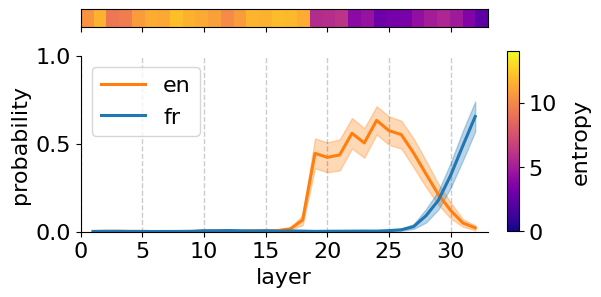

In [16]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}
fig, ax, ax2 = plot_ci_plus_heatmap(latent_token_probs, entropy, latent, color='tab:orange', tik_step=size2tik[model_size], do_colorbar=True, #, do_colorbar=(model_size=='70b'),
nums=[.99, 0.18, 0.025, 0.6])
plot_ci(ax2, out_token_probs, target_lang, color='tab:blue', do_lines=False)
ax2.set_xlabel('layer')
ax2.set_ylabel('probability')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
ax2.set_ylim(0, 1)
# make xticks start from 1
# put legend on the top left
ax2.legend(loc='upper left')
os.makedirs(f'{out_dir}/translation', exist_ok=True)

plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent.jpg', dpi=300, bbox_inches='tight')

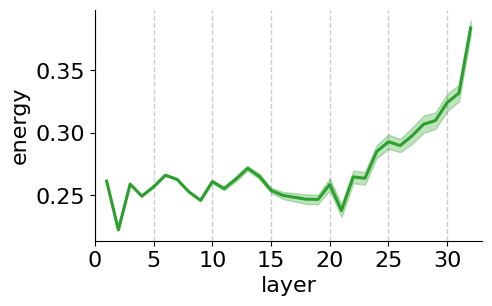

In [17]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}

fig, ax2 = plt.subplots(figsize=(5,3))
plot_ci(ax2, energy, 'energy', color='tab:green', do_lines=True, tik_step=size2tik[model_size])
ax2.set_xlabel('layer')
ax2.set_ylabel('energy')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_energy.jpg', dpi=300, bbox_inches='tight')